# Multiple linear regression

Analysis of the data from J. Durbin and G.S. Watson (1951). "Testing for Serial Correlation in
Least Squares Regression. II," Biometrika, Vol. 38 #1/2 pp. 159-177, obtained from http://users.stat.ufl.edu/~winner/datasets.html.

The dataset contains 5 colums: Year, log spirit consumption per head ($y$), log income per head ($x_1$), log realtive price of spirits ($x_2$), price/income ($x_2/x_1$).

### The model

The model used is the following:

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon $$

where the $\beta_i$ are the model parameters, and $\epsilon$ is a Gaussian noise component of the form $\mathcal{N}(0,\sigma_\epsilon)$. Thus, the model has 4 parameters, the 3 $\beta_i$ and the nuisance parameter $\sigma_\epsilon$.

### The prior

We will use uniform improper priors on $\beta_i$ and a logarithmic improper prior $\sigma_\epsilon$.

## emcee code

NOTE: run with emcee 3, there are no backwards compatibility guarantees. Uses code form [arviz#669](https://github.com/arviz-devs/arviz/pull/669)

In [1]:
import emcee
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
emcee.__version__

'2.2.1'

In [2]:
names = ["year","consumption","income","price"]
spirits_data = pd.read_csv("spirits.dat", header=None, sep="\s+", names=names, usecols=[0,1,2,3])
years = spirits_data.year
spirits_data.drop("year",axis=1,inplace=True)

In [3]:
def log_prior(theta):
    s_e = theta[-1]
    if s_e<=0:
        return -np.inf
    return -np.log(s_e)

def log_like(theta,y,x):
    b0,b1,b2,s_e = theta
    n = len(y)
    vect_like = np.dot(x,theta[1:3])+b0
    vect_like = -np.log(2*np.pi*s_e**2)/2-(y-vect_like)**2/(2*s_e**2)
    return vect_like

def model(theta,x):
    y_hat = (
        theta[0,...,None]
        +x[:,0]*theta[1,...,None]
        +x[:,1]*theta[2,...,None]
        +np.random.normal(scale=theta[-1,...,None])
    )
    return y_hat

def log_prob(theta,y,x):
    prior = log_prior(theta)
    if not np.isfinite(prior):
        return -np.inf, (np.full_like(y,np.nan), np.full_like(y,np.nan))
    vect_like = log_like(theta,y,x)
    like = np.sum(vect_like)
    return like+prior, (vect_like, model(theta,x))

In [4]:
nwalkers, ndim  = 30, 4
init_guess = np.array([0, 1, -1, 1])
pos = init_guess + np.random.normal(scale=.1, size=(nwalkers, ndim))

In [5]:
args = [spirits_data.consumption.values, spirits_data[["income", "price"]].values]
ndraws = 5000
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=args)
sampler.run_mcmc(pos, ndraws);

In [6]:
blob_groups = ["sample_stats", "posterior_predictive"]
blob_names = ["log_likelihood", "y"]
dims = {"y":["year"], "x":["year","predictor"], "log_likelihood": ["year"]}
coords = {"year":years,"predictor":["income","price"]}
idata = az.from_emcee(
    sampler, var_names=["b0","b1","b2","s_e"], arg_names=['y', 'x'], dims=dims, 
    coords=coords, blob_names=blob_names, blob_groups=blob_groups
)
burnin = 1000
idata.sel(draw=slice(burnin,None))

In [7]:
idata

Inference data with groups:
	> posterior
	> observed_data
	> posterior_predictive
	> sample_stats

Below there are some examples of ArviZ capabilities, some of which require the presence of sample_stats and posterior_predictive information. 

/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/arviz/stats/stats.py:514: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


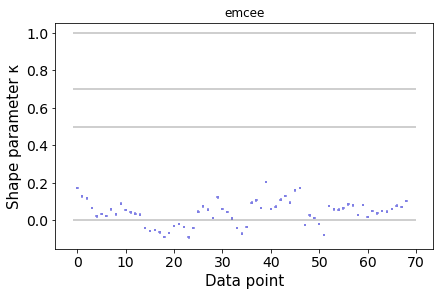

In [8]:
loo_df = az.loo(idata,pointwise=True)
ax = az.plot_khat(loo_df.pareto_k)
ax.set_title("emcee");

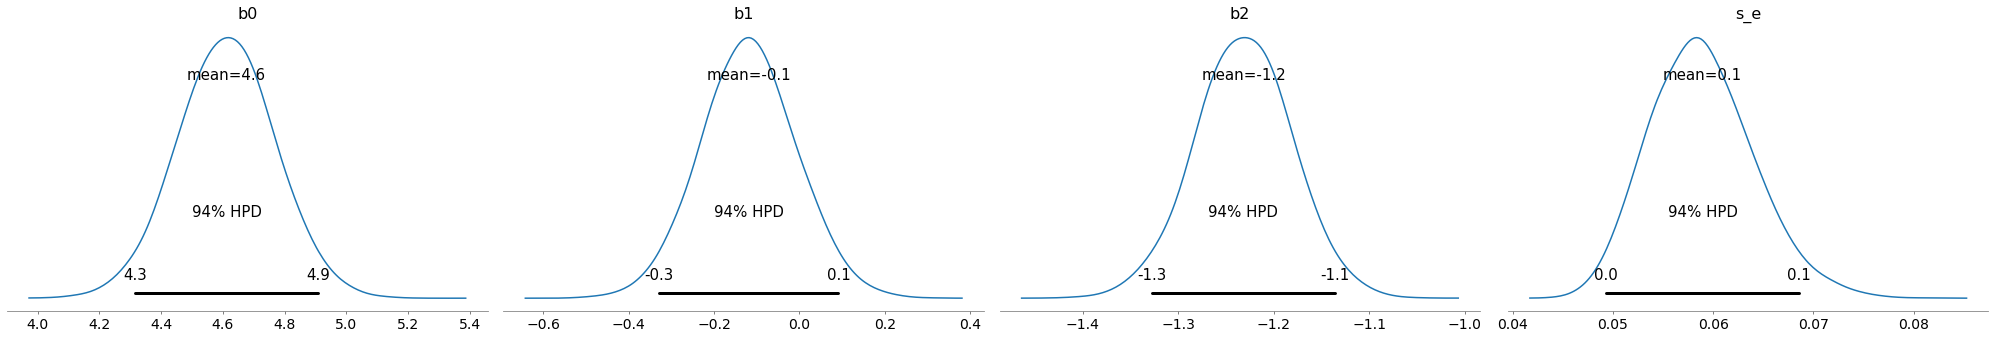

In [9]:
az.plot_posterior(idata);

In [10]:
x = idata.observed_data.y.coords["year"].values
y_hats = idata.posterior_predictive.y.values.reshape((-1,69))
az.plot_hpd(x, y_hats,fill_kwargs={"label": "95% credibility interval"});
plt.plot(x, idata.posterior_predictive.y.mean(dim=["draw", "chain"]),color='red',label="Posterior predictive mean")
plt.plot(x, idata.observed_data.y.values,color='k',label="Observed data")
plt.legend(); plt.ylabel("Log spirit consumption per head");
plt..set_title("emcee");

SyntaxError: invalid syntax (<ipython-input-10-480b39bb5ebc>, line 7)